# Ultra-Reliability in Two-Ray Ground Reflection Scenarios

_Author:_ Karl-Ludwig Besser, Technische Universität Braunschweig, Germany

This notebook is part of the paper "A Simple Frequency Diversity Scheme for Ultra-Reliable Communications in Ground Reflection Scenarios" (Karl-Ludwig Besser, Eduard Jorswieck, and Justin Coon. 2022).  
If you use any of this work, please cite the above paper.

> If you are not familiar with Jupyter notebooks: The easiest way to use this notebook interactively, is to hit `Kernel --> Restart & Run All` in the menu. The will execute all cells and enable the interactive elements of the plots.  
> Alternatively, you can execute the cells one by one using Shift+Return

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import interact

## Single Frequency

In [2]:
from single_frequency import rec_power, crit_dist, to_decibel

In [3]:
def plot_rec_power_single_freq(freq, h_tx, h_rx):
    if freq > 1e9:
        _num_steps = 5000
    else:
        _num_steps = 2000
    distance = np.logspace(0, 3, _num_steps)
    crit_distances = crit_dist(freq, h_tx, h_rx)
    
    fig, axs = plt.subplots()
    _lim_power = [-130, -40]
    axs.set_ylim(_lim_power)
    axs.set_xlim([min(distance), max(distance)])
    plot_power = axs.semilogx(distance, np.ones_like(distance))[0]
    plot_dist = axs.vlines(crit_distances, _lim_power[0], _lim_power[1],
                           colors='k', linestyles='dashed', alpha=.2)
    
    def update_plot(rho=1.):
        G_ref = rho**2
        power_rx = rec_power(distance, freq, h_tx, h_rx, G_ref=G_ref)
        power_rx_db = to_decibel(power_rx)
        plot_power.set_ydata(power_rx_db)
    interact(update_plot, rho=(0, 1, .001))

interactive(children=(FloatSlider(value=1.0, description='rho', max=1.0, step=0.001), Output()), _dom_classes=…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
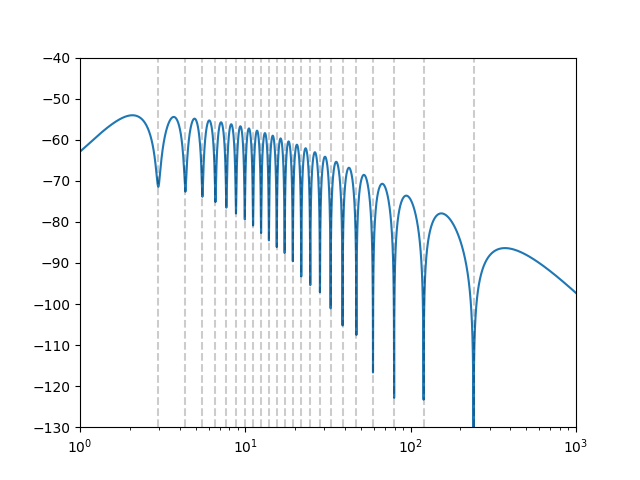

In [4]:
plot_rec_power_single_freq(freq=2.4e9, h_tx=10, h_rx=1.5)

## Two Frequencies

In [5]:
from two_frequencies import sum_power_lower_envelope

In [6]:
def plot_sum_power_two_freq(freq, h_tx, h_rx):
    if freq > 1e9:
        _num_steps = 5000
    else:
        _num_steps = 2000
    distance = np.logspace(0, 3, _num_steps)
    
    fig, axs = plt.subplots()
    _lim_power = [-130, -40]
    axs.set_ylim(_lim_power)
    axs.set_xlim([min(distance), max(distance)])
    plot_power = axs.semilogx(distance, np.ones_like(distance))[0]
    plot_power_envelope = axs.semilogx(distance, np.ones_like(distance))[0]
    
    def update_plot(df=8):
        df = 10**df
        print(f"Delta Freq: {df:E} Hz")
        power_rx1 = rec_power(distance, freq, h_tx, h_rx)
        power_rx2 = rec_power(distance, freq+df, h_tx, h_rx)
        power_rx = 0.5*(power_rx1+power_rx2)
        power_rx_db = to_decibel(power_rx)
        
        power_env = sum_power_lower_envelope(distance, df, freq, h_tx, h_rx)
        power_env_db = to_decibel(power_env)
        
        plot_power.set_ydata(power_rx_db)
        plot_power_envelope.set_ydata(power_env_db)
    interact(update_plot, df=(5, 9, .01))

interactive(children=(FloatSlider(value=8.0, description='df', max=9.0, min=5.0, step=0.01), Output()), _dom_c…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
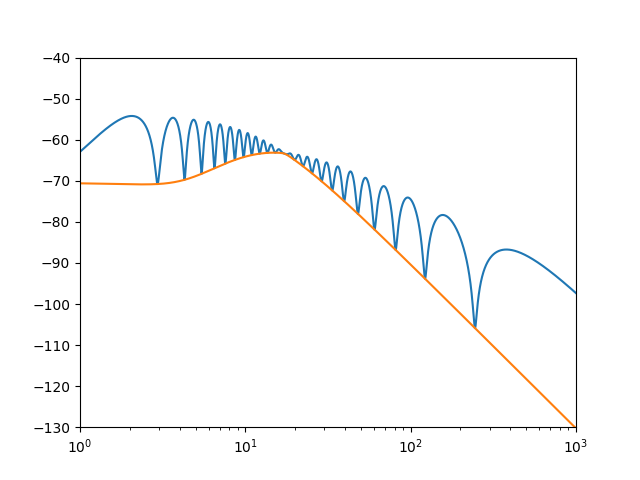

In [7]:
plot_sum_power_two_freq(freq=2.4e9, h_tx=10, h_rx=1.5)

### Optimal Frequency Spacing

In [8]:
from optimal_frequency_distance import find_optimal_delta_freq
from single_frequency import min_rec_power_single_freq

In [9]:
def plot_optimized_rec_power(d_min, d_max, freq, h_tx, h_rx):
    if freq > 1e9:
        _num_steps = 4000
    else:
        _num_steps = 2000
        
    distance = np.logspace(np.log10(d_min)-.1, np.log10(d_max)+.1, _num_steps)
    
    power_rx_single = rec_power(distance, freq, h_tx, h_rx)
    power_rx_single_db = to_decibel(power_rx_single)
    min_power_single = min_rec_power_single_freq(d_min, d_max, freq, h_tx, h_rx)
    min_power_single_db = to_decibel(min_power_single)
    print(f"Minimum power single frequency: {min_power_single_db:.2f} dB")
    
    opt_df = find_optimal_delta_freq(d_min, d_max, freq, h_tx, h_rx)
    print(f"Optimal frequency spacing: {opt_df:E}")
    power_rx_opt = sum_power_lower_envelope(distance, opt_df, freq, h_tx, h_rx)
    power_rx_opt_db = to_decibel(power_rx_opt)
    min_power_two = sum_power_lower_envelope(d_max, opt_df, freq, h_tx, h_rx)
    min_power_two_db = to_decibel(min_power_two)
    print(f"Minimum power two frequencies: {min_power_two_db:.2f} dB")
    
    power_rx_opt_exact = .5*(power_rx_single + rec_power(distance, freq+opt_df, h_tx, h_rx))
    power_rx_opt_exact_db = to_decibel(power_rx_opt_exact)

    fig, axs = plt.subplots()
    _lim_power = [-130, -40]
    axs.set_ylim(_lim_power)
    axs.set_xlim([min(distance), max(distance)])
    
    axs.vlines(d_min, *_lim_power, ls="--", color="k", alpha=.75)
    axs.vlines(d_max, *_lim_power, ls="--", color="k", alpha=.75)
    
    axs.semilogx(distance, power_rx_single_db, '-b', label="Single Frequency")
    axs.semilogx(distance, power_rx_opt_db, '-r', label="Lower Bound")
    axs.semilogx(distance, power_rx_opt_exact_db, '-', c='orange', alpha=.8, label="Two Freq. - Optimal$\Delta f$")
    
    axs.hlines(min_power_single_db, min(distance), max(distance), ls='--', color='b', label="Min Power Single")
    axs.hlines(min_power_two_db, min(distance), max(distance), ls='--', color='r', label="Min Power Two Freq.")
    
    axs.legend()
    axs.set_xlabel("Distance $d$ [m]")
    axs.set_ylabel("Receive Power $P_r$ [dB]")

Minimum power single frequency: -124.71 dB
Optimal frequency spacing: 1.769012E+08
Minimum power two frequencies: -85.67 dB


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
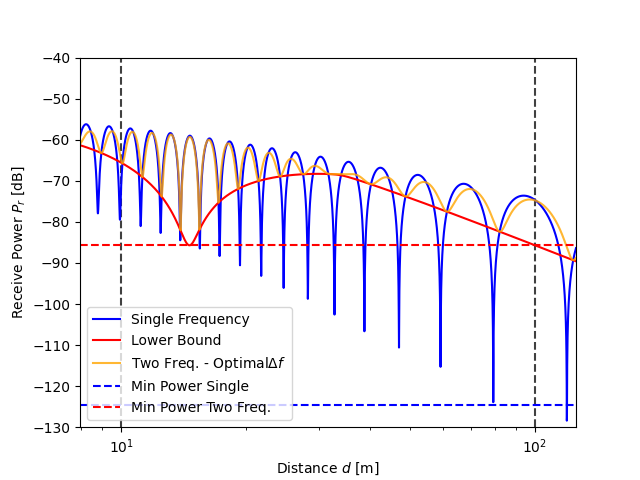

In [10]:
plot_optimized_rec_power(10, 100, 2.4e9, 10, 1.5)

## Rate Analysis

In [11]:
from rate_comparison import rate_single_freq, rate_two_freq, rate_two_freq_lower

In [12]:
def plot_rate(d_min, d_max, freq, h_tx, h_rx, bw):
    if freq > 1e9:
        _num_steps = 4000
    else:
        _num_steps = 2000

    distance = np.logspace(np.log10(d_min)-.1, np.log10(d_max)+.1, 3000)
    _min_power_single = min_rec_power_single_freq(d_min, d_max, freq, h_tx, h_rx)

    df = find_optimal_delta_freq(d_min, d_max, freq, h_tx, h_rx)
    print(f"Frequency spacing: {df:E}")

    rate_single = rate_single_freq(distance, freq, h_tx, h_rx, bw=bw)
    rate_two = rate_two_freq(distance, freq, df, h_tx, h_rx, bw=bw)
    rate_two_lower =  rate_two_freq_lower(distance, freq, df, h_tx, h_rx, d_max=d_max, bw=bw)
    
    fig, axs = plt.subplots()
    _lim_rate = [1e3, 1e7]
    axs.set_ylim(_lim_rate)
    axs.set_xlim([min(distance), max(distance)])
    
    axs.vlines(d_min, *_lim_rate, ls="--", color="k", alpha=.75)
    axs.vlines(d_max, *_lim_rate, ls="--", color="k", alpha=.75)
    
    axs.loglog(distance, rate_single, '-b', label="Single Frequency")
    axs.loglog(distance, rate_two, '-r', label="Two Freq. - Optimal $\Delta f$")
    axs.loglog(distance, rate_two_lower, '--r', alpha=.5, label="Two Freq. Lower Bound")
    axs.set_xlabel("Distance $d$ [m]")
    axs.set_ylabel("Achievable Rate [bit/s/Hz]")
    axs.legend()

Frequency spacing: 1.769012E+08


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
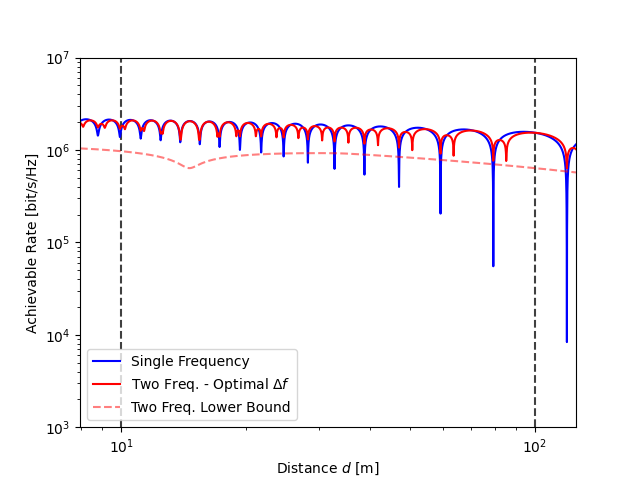

In [13]:
plot_rate(10, 100, 2.4e9, 10, 1.5, 100e3)

## Outage Probability and UAV Example

For running the outage probability examples and the UAV example, please use the provided Python scripts directly. The correct command can also be found in the `run.sh` file.